Based on Milestone 3 - the GCN model be used that for figuring out feature importance.

#Imports

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.5.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 29.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.explain import GNNExplainer  # GNNExplainer
import os
import seaborn as sns

Loading data used in milstone 3 for training the model
Redefining and loading the model used in milestone - 3.

## Data

In [ ]:
from google.colab import drive

drive.mount('/content/drive') # Remember to add the folder (as a shortcut) to your drive before running this cell
%cd /content/drive/MyDrive/PROJECT_CS547_IE534

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1ebKvoK7afoaMA3BiVP8gBiRPCDUjeorO/PROJECT_CS547_IE534


In [ ]:
# Load training data (with one-hot encoding and without)
training_with_onehot = pd.read_pickle('training_data_with_onehot.pkl').reset_index(drop=True)
training_without_onehot = pd.read_pickle('training_data_without_onehot.pkl').reset_index(drop=True)

# Target and features
TARGET = 'end_station_name'  # Target variable

In [ ]:
df = training_without_onehot

In [ ]:
# Extract latitude and longitude for start stations
start_station_locations = df[['start_lat', 'start_lng']].dropna()

In [ ]:
start_stations = set(df['start_station_name'].unique())
end_stations = set(df[TARGET].unique())
total_stations = start_stations.union(end_stations)
print("Total Number of Stations:", len(total_stations))

Total Number of Stations: 2181


In [ ]:
station_to_int = {station: i for i, station in enumerate(total_stations)}
int_to_station = {i: station for i, station in enumerate(total_stations)}

In [ ]:
df['start_station_index'] = df['start_station_name'].map(station_to_int)
df['end_station_index'] = df['end_station_name'].map(station_to_int)

In [ ]:
def encode_time_cyclically(datetime_series):
  hours = datetime_series.dt.hour
  minutes = datetime_series.dt.minute
  seconds = datetime_series.dt.second

  fraction_of_day = (hours + minutes / 60 + seconds / 3600) / 24
  sin_time = np.sin(2 * np.pi * fraction_of_day)
  cos_time = np.cos(2 * np.pi * fraction_of_day)

  return sin_time, cos_time

In [ ]:
df['start_time_sin'], df['start_time_cos'] = encode_time_cyclically(df['started_at'])
df['end_time_sin'], df['end_time_cos'] = encode_time_cyclically(df['ended_at'])

In [ ]:
df = df.rename(columns={'member_casual':'member_status'})
df = pd.get_dummies(df, columns=['rideable_type', 'Month', 'Day_of_Week', 'member_status'], dtype=float)

In [ ]:
df['Weather_PRCP'] = df['Weather_PRCP'].ffill()
df['Weather_SNOW'] = df['Weather_SNOW'].ffill()
df['Weather_AVG_WIND'] = df['Weather_AVG_WIND'].ffill()
df['Weather_TMAX'] = df['Weather_TMAX'].ffill()
df['Weather_TMIN'] = df['Weather_TMIN'].ffill()

In [ ]:
print(df.isna().sum())

started_at                     0
Exact_start_Time               0
ended_at                       0
duration                       0
start_station_name             0
start_lat                      0
start_lng                      0
Weather_PRCP                   0
Weather_AVG_WIND               0
Weather_TMAX                   0
Weather_TMIN                   0
Weather_SNOW                   0
end_station_name               0
end_lat                        0
end_lng                        0
start_station_index            0
end_station_index              0
start_time_sin                 0
start_time_cos                 0
end_time_sin                   0
end_time_cos                   0
rideable_type_classic_bike     0
rideable_type_electric_bike    0
Month_April                    0
Month_August                   0
Month_December                 0
Month_February                 0
Month_January                  0
Month_July                     0
Month_June                     0
Month_Marc

In [ ]:
from sklearn.preprocessing import StandardScaler

features_to_normalize = ['duration', 'Weather_PRCP',
       'Weather_AVG_WIND', 'Weather_TMAX', 'Weather_TMIN', 'Weather_SNOW']

scaler = StandardScaler()
df.loc[:, features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

In [ ]:
node_features_list = ['start_lat', 'start_lng', 'duration', 'Weather_PRCP',
       'Weather_AVG_WIND', 'Weather_TMAX', 'Weather_TMIN', 'Weather_SNOW',
       'start_time_sin', 'start_time_cos', 'end_time_sin', 'end_time_cos',
       'rideable_type_classic_bike', 'rideable_type_electric_bike',
       'Month_April', 'Month_August', 'Month_December', 'Month_February',
       'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May',
       'Month_November', 'Month_October', 'Month_September',
       'Day_of_Week_Friday', 'Day_of_Week_Monday', 'Day_of_Week_Saturday',
       'Day_of_Week_Sunday', 'Day_of_Week_Thursday', 'Day_of_Week_Tuesday',
       'Day_of_Week_Wednesday', 'member_status_casual',
       'member_status_member']
edge_index_list = ['start_station_index', 'end_station_index']
target_feature_list = ['end_lat', 'end_lng']

In [ ]:
node_features = torch.tensor(df[node_features_list].values, dtype=torch.float)
edge_index = torch.tensor(df[edge_index_list].values, dtype=torch.int64)
target_features = torch.tensor(df[target_feature_list].values, dtype=torch.float)

In [ ]:
data = Data(x=node_features, edge_index=edge_index.t().contiguous(), y=target_features)

##Model

In [ ]:
data

Data(x=[120000, 35], edge_index=[2, 120000], y=[120000, 2])

In [ ]:
from torch_geometric.loader import NeighborLoader
batch_size = 500
loader = NeighborLoader(data, num_neighbors=[10, 10], batch_size=batch_size, input_nodes=None)

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [ ]:
class BasicGCN(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels):
    super(BasicGCN, self).__init__()
    self.conv1 = GCNConv(in_channels, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, hidden_channels)
    self.fc = torch.nn.Linear(hidden_channels, 2)

  def forward(self, x, edge_index):

    x = F.relu(self.conv1(x, edge_index))
    x = F.relu(self.conv2(x, edge_index))

    x = self.fc(x)
    return x

In [ ]:
def mini_batch_train(model, loader, optimizer, criterion, epochs=100, verbose=False):
  for epoch in range(epochs):
    model.train()
    for batch in loader:
      optimizer.zero_grad()
      out = model(batch.x, batch.edge_index)
      loss = criterion(out, batch.y)
      loss.backward()
      optimizer.step()

    if (verbose and epoch % 10 == 0) or epoch == epochs - 1:
      print(f'Epoch {epoch}, Loss: {loss.item()}')
  return model

In [ ]:
in_channels = node_features.shape[1]
hidden_channels = 50
model = BasicGCN(in_channels, hidden_channels)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()
epochs = 100

In [ ]:
model = mini_batch_train(model, loader, optimizer, criterion, epochs=epochs, verbose=True)

Epoch 0, Loss: 0.05431097745895386
Epoch 10, Loss: 0.014173202216625214
Epoch 20, Loss: 0.014238071627914906
Epoch 30, Loss: 0.005775534547865391
Epoch 40, Loss: 0.0034139074850827456
Epoch 50, Loss: 0.004619053099304438
Epoch 60, Loss: 0.004889495670795441
Epoch 70, Loss: 0.003057334804907441
Epoch 80, Loss: 0.0012376317754387856
Epoch 90, Loss: 0.001231927890330553
Epoch 99, Loss: 0.001240008627064526


# Feature Importance - GNNExplainer

In [ ]:
from torch_geometric.explain import GNNExplainer

In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.nn import MessagePassing

# Assuming your model is a MessagePassing model:
# If not, you'll need to adapt this part.
explainer = Explainer(
    model,
    algorithm=GNNExplainer(),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',  # or 'multiclass_classification', 'regression'
        task_level='node',  # Added task_level as 'node' for node-level prediction
        return_type='raw'  # Specify the return type as 'raw' for regression tasks
    )
)

In [ ]:
# Explain the prediction for a specific node
node_idx = 0  # Index of the node you want to explain
target_class = 1  # You can choose the output class you want to explain

# Run the explainer with the `target` argument specified
# Pass edge_index as a keyword argument
explanation = explainer(x=data.x, edge_index=data.edge_index, index=node_idx, target=target_class)

/usr/local/lib/python3.10/dist-packages/torch_geometric/explain/explainer.py:193: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(


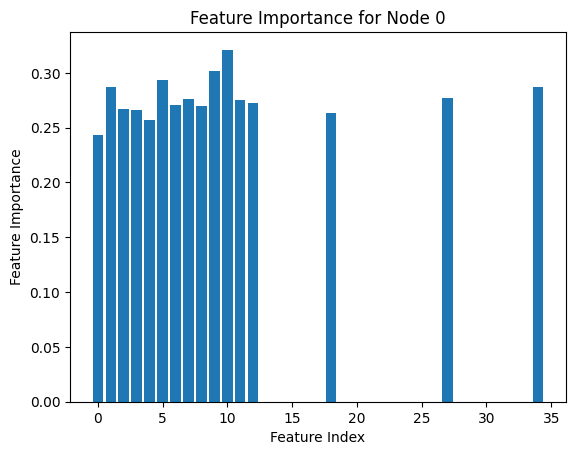

In [ ]:
# Visualize feature importance for the specific node
node_feat_mask = explanation.node_mask  # Access the node_mask attribute instead of node_feat_mask

# Get the feature importance for the specific node (node_idx)
node_importance = node_feat_mask[node_idx]

# Now plot the feature importances for this specific node
plt.bar(range(len(node_importance)), node_importance.detach().numpy()) # Detach from the computation graph and convert to numpy array
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title(f'Feature Importance for Node {node_idx}')
plt.show()

/usr/local/lib/python3.10/dist-packages/torch_geometric/explain/explainer.py:193: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(


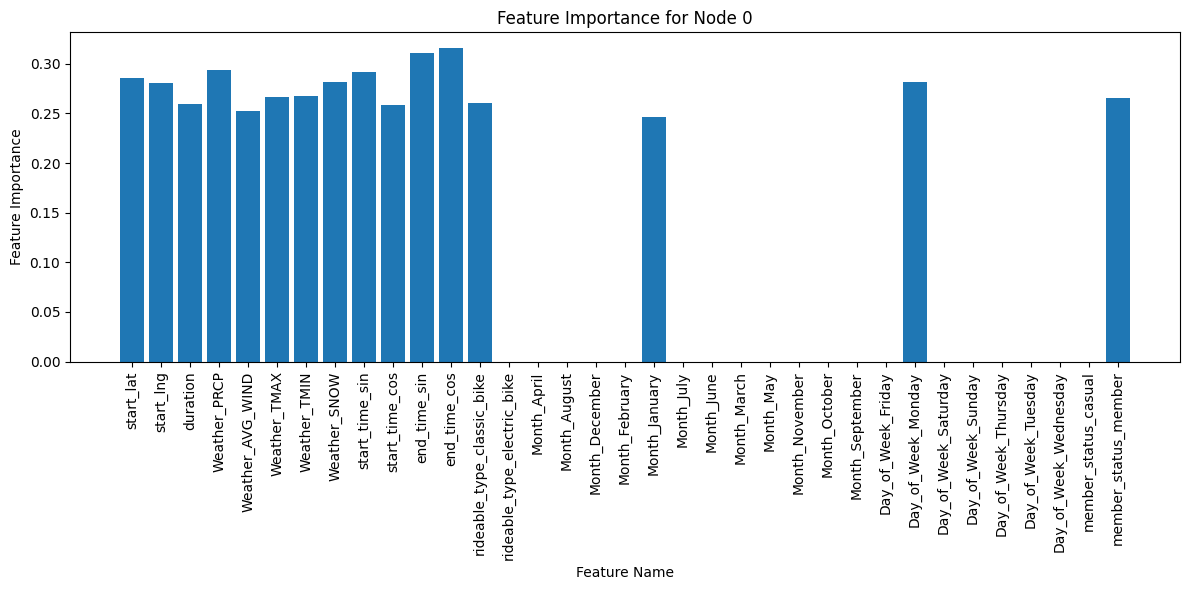

In [ ]:
# Assuming your model is a MessagePassing model:
# If not, you'll need to adapt this part.
explainer = Explainer(
    model,
    algorithm=GNNExplainer(),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',  # or 'multiclass_classification', 'regression'
        task_level='node',  # Added task_level as 'node' for node-level prediction
        return_type='raw'  # Specify the return type as 'raw' for regression tasks
    )
)
# Explain the prediction for a specific node
node_idx = 0  # Index of the node you want to explain
target_class = 1  # You can choose the output class you want to explain

# Run the explainer with the `target` argument specified
# Pass edge_index as a keyword argument
explanation = explainer(x=data.x, edge_index=data.edge_index, index=node_idx, target=target_class)
# Visualize feature importance for the specific node
node_feat_mask = explanation.node_mask  # Access the node_mask attribute instead of node_feat_mask

# Get the feature importance for the specific node (node_idx)
node_importance = node_feat_mask[node_idx]

# Now plot the feature importances for this specific node with feature names
feature_names = node_features_list
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.bar(feature_names, node_importance.detach().numpy()) # Detach from the computation graph and convert to numpy array
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.title(f'Feature Importance for Node {node_idx}')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()       # Adjust layout to prevent labels from overlapping
plt.show()

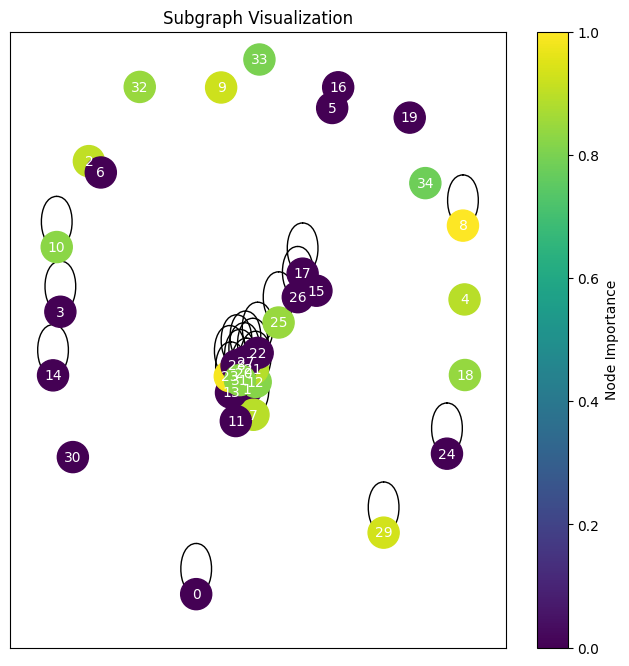

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming 'explanation' object from the previous code is available

# Extract the subgraph from the explanation
subgraph_edge_index = explanation.edge_index

# Create a NetworkX graph from the subgraph edge indices
subgraph = nx.Graph()
subgraph.add_edges_from(subgraph_edge_index.t().cpu().numpy()) # Convert to numpy array for networkx

# Get node features from the original graph data
node_features = data.x.cpu().numpy()

# Now visualize the subgraph
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

# Get the node indices in the subgraph
subgraph_nodes = list(subgraph.nodes())

# Create a color map for node importance
cmap = plt.get_cmap('viridis')

valid_indices = list(range(len(node_importance)))  # Valid indices for node_importance
subgraph_nodes_valid = [node for node in subgraph_nodes if node in valid_indices]

# If no valid nodes are found, skip the visualization
if not subgraph_nodes_valid:
    print("No valid nodes found in the subgraph for visualization.")
else:
    # Get the node importance for the valid subgraph nodes
    # and normalize to 0-1 range for color mapping
    node_importance_subgraph = node_importance[subgraph_nodes_valid].detach().numpy()
    node_importance_subgraph = (node_importance_subgraph - node_importance_subgraph.min()) / (
                node_importance_subgraph.max() - node_importance_subgraph.min()
    )

    # Get node colors based on normalized importance
    node_colors = [cmap(importance) for importance in node_importance_subgraph]

    # Create a subgraph with only the valid nodes
    valid_subgraph = subgraph.subgraph(subgraph_nodes_valid)

    # Now visualize the valid subgraph
    # Calculate positions for nodes using spring layout
    pos = nx.spring_layout(valid_subgraph)

    # Draw the nodes and edges with the calculated positions
    # and assign the return value to node_collection for colorbar
    node_collection = nx.draw_networkx_nodes(valid_subgraph, pos, node_color=node_colors, node_size=500)
    nx.draw_networkx_edges(valid_subgraph, pos)

    # Add labels to the nodes
    nx.draw_networkx_labels(valid_subgraph, pos, font_size=10, font_color='white')


    plt.title('Subgraph Visualization')
    # Use the node_collection for the colorbar
    plt.colorbar(node_collection, label='Node Importance')
    plt.show()

Summary -


*   The notebook builds on a prior milestone where a Graph Convolutional Network (GCN) model was used.
*   The goal was to determine feature importance within the GCN framework.
*   Dependencies such as torch-scatter, torch-sparse, and pytorch_geometric were installed for PyTorch Geometric, enabling GNN operations.
*   Initial attempts to use SHAP for explaining feature importance in GNNs encountered difficulties, as SHAP is not inherently designed for GNN architectures.
*  GNNExplainer, a tool specifically designed for GNNs, was employed successfully and provided insights into feature importance.


Feature Importance -
* Features such as start_lat, start_lng, and duration have high importance, indicating their strong contribution to the model's predictions for Node 0.
* Temporal features like start_time_cos and end_time_cos also play a significant role.
* Certain categorical features, like Day_of_Week_Monday and member_status_member, show notable importance, highlighting the impact of user-related and temporal categories.
* Many monthly features (Month_April, Month_July, etc.) have zero or negligible importance, suggesting they are not significant for Node 0's predictions.
* The nodes in the center of the graph (e.g., 11, 12, 13) have the highest importance, as indicated by the yellow coloration. These nodes likely play a critical role in the overall graph structure or specific predictions.

